In [1]:
import sys

sys.path = [p for p in sys.path if 'vast-1.4.2' not in p]
sys.path.insert(0, '/global/u2/z/ziqi/.local/lib/python3.9/site-packages/vast-1.6.1-py3.9-linux-x86_64.egg')

import vast
print("VAST imported successfully.")
print("Python executable:", sys.executable)
print("Python version:", sys.version)
print("VAST version:", vast.__version__)


VAST imported successfully.
Python executable: /global/homes/z/ziqi/python3.9/bin/python3.9
Python version: 3.9.9 (main, Nov 15 2024, 02:35:40) 
[GCC 12.3.0]
VAST version: 1.6.1


In [2]:
import os
import numpy as np

from astropy.table import QTable, Table
import fitsio
import pickle

from vast.catalog import void_catalog as vc
from vast.catalog.void_catalog import VoidFinderCatalogStacked

from vast.voidfinder import vflag
from vast.voidfinder import find_voids, filter_galaxies
from vast.voidfinder.multizmask import generate_mask
from vast.voidfinder.preprocessing import file_preprocess
from vast.voidfinder.vflag import determine_vflag
from vast.voidfinder.distance import z_to_comoving_dist
from vast.voidfinder import ra_dec_to_xyz
#from vast.voidfinder.postprocessing import open_fits_file

from scipy.special import logsumexp, betaln, gammaln
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy import conf
from astropy.table import Table
from astropy.coordinates import Distance
from astropy.cosmology import Planck18, LambdaCDM

# Classify Galaxies using VoidFinder

In [ ]:

################################################################################
# USER INPUT
#-------------------------------------------------------------------------------
ngc_file = 'DESIVAST_NGC_VoidFinder_Output.fits'
sgc_file = 'DESIVAST_SGC_VoidFinder_Output.fits'

galaxy_file = "BGS_filtered_data.fits"


dist_metric = 'comoving'
Omega_M = 0.26
h = 1
DtoR = np.pi / 180
################################################################################


################################################################################
# IMPORT AND PREPARE GALAXY DATA
#-------------------------------------------------------------------------------
print('Importing galaxy data to be classified')

# Read in the FITS file for galaxies to be classified
galaxies = Table.read(galaxy_file, format='fits')


# Rename columns to standard names
galaxies['ra'] = galaxies['RA']
galaxies['dec'] = galaxies['DEC']
galaxies['redshift'] = galaxies['Z']


print('Galaxy data imported')
################################################################################


################################################################################
# IMPORT VOID CATALOG AND MASK (NGC)
#-------------------------------------------------------------------------------
print('Importing NGC void data and mask')

with fits.open(ngc_file) as hdul_ngc:

    print("Catalog information:")
    hdul_ngc.info()

    primary_header_ngc = hdul_ngc[0].header
    dist_limits_ngc = [primary_header_ngc['DLIML'], primary_header_ngc['DLIMU']]
    mask_ngc = hdul_ngc[1].data
    mask_resolution_ngc = hdul_ngc[1].header['MSKRES']
    voids_ngc = hdul_ngc['HOLES'].data

#print('NGC void data and mask imported')
################################################################################

print("voids_ngc column names:")
print(voids_ngc.columns)

In [ ]:
num_rows = len(galaxies['ra'])
print(f"Number of rows in 'ra' column: {num_rows}")

In [ ]:
################################################################################
# CONVERT GALAXY ra, dec, z TO x, y, z COORDINATES
#-------------------------------------------------------------------------------
print('Converting coordinate system')

# Convert redshift to distance
if dist_metric == 'comoving':
    if 'Rgal' not in galaxies.columns:
        galaxies['Rgal'] = z_to_comoving_dist(galaxies['redshift'].data.astype(np.float32), Omega_M, h)
    galaxies_r = galaxies['Rgal']
else:
    c = 3e5  # km/s
    H = 100 * h
    galaxies_r = c * galaxies['redshift'] / H


galaxies_x = galaxies_r * np.cos(galaxies['dec'] * DtoR) * np.cos(galaxies['ra'] * DtoR)
galaxies_y = galaxies_r * np.cos(galaxies['dec'] * DtoR) * np.sin(galaxies['ra'] * DtoR)
galaxies_z = galaxies_r * np.sin(galaxies['dec'] * DtoR)

print('Coordinates converted')
################################################################################



In [ ]:
################################################################################
# IDENTIFY LARGE-SCALE ENVIRONMENT (NGC)
#-------------------------------------------------------------------------------
print('Identifying environment in NGC')

galaxies['vflag'] = -9  # Initialize vflag column for NGC

# Iterate over all galaxies to classify for NGC
for i in range(len(galaxies)):
    galaxies['vflag'][i] = determine_vflag(
        galaxies_x[i], 
        galaxies_y[i], 
        galaxies_z[i], 
        voids_ngc,   #exclude edge voids
        mask_ngc, 
        mask_resolution_ngc, 
        dist_limits_ngc[0], 
        dist_limits_ngc[1]
    )
    if (i + 1) % 50000 == 0:
        print(f'Processed {i + 1} galaxies out of {len(galaxies)}')

print('NGC environments identified')
################################################################################


In [ ]:
################################################################################
# SAVE RESULTS
#-------------------------------------------------------------------------------
print('Saving classified galaxies')

output_filename = 'BGS_classified_galaxies.fits'
galaxies.write(output_filename, format='fits', overwrite=True)

print('Results saved to', output_filename)
print(len(galaxies['vflag']))
################################################################################

In [ ]:
num_wall_galaxies = np.sum(galaxies['vflag'] == 0)
print(f"Wall Galaxies (vflag = 0): {num_wall_galaxies}")

num_void_galaxies = np.sum(galaxies['vflag'] == 1)
print(f"Void Galaxies (vflag = 1): {num_void_galaxies}")

num_wall_galaxies = np.sum(galaxies['vflag'] == 2)
print(f"Edge Galaxies (vflag = 2): {num_wall_galaxies}")

num_void_galaxies = np.sum(galaxies['vflag'] == 9)
print(f"Out Galaxies (vflag = 9): {num_void_galaxies}")


# Galaxy Property Plots 

In [3]:
galaxy_file = "BGS_classified_galaxies.fits"

galaxies = Table.read(galaxy_file, format='fits')

print("Original column names:", galaxies.colnames)

#print(len(galaxies['Halpha_EW']))

Original column names: ['Z', 'DEC', 'RA', 'ABS_MAG_R', 'ABS_MAG_U', 'ABS_MAG_G', 'LOG_MSTAR', 'HALPHA', 'HBETA', 'SFR', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'Color_ur', 'Color_gr', 'Halpha_EW', 'ra', 'dec', 'redshift', 'Rgal', 'vflag']


In [4]:
import matplotlib.pyplot as plt

# Wall Galaxies (vflag == 0)
wall_abs_mag_VF = galaxies['ABS_MAG_R'][galaxies['vflag'] == 0]
wall_log_mstar_VF = galaxies['LOG_MSTAR'][galaxies['vflag'] == 0]
wall_color_ur_VF = galaxies['Color_ur'][galaxies['vflag'] == 0]
wall_color_gr_VF = galaxies['Color_gr'][galaxies['vflag'] == 0]
wall_HalphaEW_VF = galaxies['Halpha_EW'][galaxies['vflag'] == 0]

# Void Galaxies (vflag == 1)
void_abs_mag_VF = galaxies['ABS_MAG_R'][galaxies['vflag'] == 1]
void_log_mstar_VF = galaxies['LOG_MSTAR'][galaxies['vflag'] == 1]
void_color_ur_VF = galaxies['Color_ur'][galaxies['vflag'] == 1]
void_color_gr_VF = galaxies['Color_gr'][galaxies['vflag'] == 1]
void_HalphaEW_VF = galaxies['Halpha_EW'][galaxies['vflag'] == 1]

'''

wall_apparentmag_VF = galaxies['apparent_magnitude'][galaxies['vflag'] == 0]   #from Flux_R
wall_app_VF = galaxies['APP_MAG'][galaxies['vflag'] == 0]   #from abs mag

void_apparentmag_VF = galaxies['apparent_magnitude'][galaxies['vflag'] == 1] #from Flux_R
void_app_VF = galaxies['APP_MAG'][galaxies['vflag'] == 1]   #from abs mag

print(len(wall_abs_mag_VF),len(void_abs_mag_VF))
print(len( galaxies['ABS_MAG_R'][galaxies['vflag'] == 2]))
print(len( galaxies['ABS_MAG_R'][galaxies['vflag'] == 9]))
'''

"\n\nwall_apparentmag_VF = galaxies['apparent_magnitude'][galaxies['vflag'] == 0]   #from Flux_R\nwall_app_VF = galaxies['APP_MAG'][galaxies['vflag'] == 0]   #from abs mag\n\nvoid_apparentmag_VF = galaxies['apparent_magnitude'][galaxies['vflag'] == 1] #from Flux_R\nvoid_app_VF = galaxies['APP_MAG'][galaxies['vflag'] == 1]   #from abs mag\n\nprint(len(wall_abs_mag_VF),len(void_abs_mag_VF))\nprint(len( galaxies['ABS_MAG_R'][galaxies['vflag'] == 2]))\nprint(len( galaxies['ABS_MAG_R'][galaxies['vflag'] == 9]))\n"

In [5]:
abs_mag_r_total = (
    galaxies['ABS_MAG_R'][galaxies['vflag'] == 0].tolist() + 
    galaxies['ABS_MAG_R'][galaxies['vflag'] == 1].tolist() + 
    galaxies['ABS_MAG_R'][galaxies['vflag'] == 2].tolist()
)
logmstar_total = (
    galaxies['LOG_MSTAR'][galaxies['vflag'] == 0].tolist() + 
    galaxies['LOG_MSTAR'][galaxies['vflag'] == 1].tolist() + 
    galaxies['LOG_MSTAR'][galaxies['vflag'] == 2].tolist()
)
ur_total = (
    galaxies['Color_ur'][galaxies['vflag'] == 0].tolist() + 
    galaxies['Color_ur'][galaxies['vflag'] == 1].tolist() + 
    galaxies['Color_ur'][galaxies['vflag'] == 2].tolist()
)
gr_total = (
    galaxies['Color_gr'][galaxies['vflag'] == 0].tolist() + 
    galaxies['Color_gr'][galaxies['vflag'] == 1].tolist() + 
    galaxies['Color_gr'][galaxies['vflag'] == 2].tolist()
)

HalphaEW = (
    galaxies['Halpha_EW'][galaxies['vflag'] == 0].tolist() + 
    galaxies['Halpha_EW'][galaxies['vflag'] == 1].tolist() + 
    galaxies['Halpha_EW'][galaxies['vflag'] == 2].tolist()
)

## Comparison between unimodal and bimodal

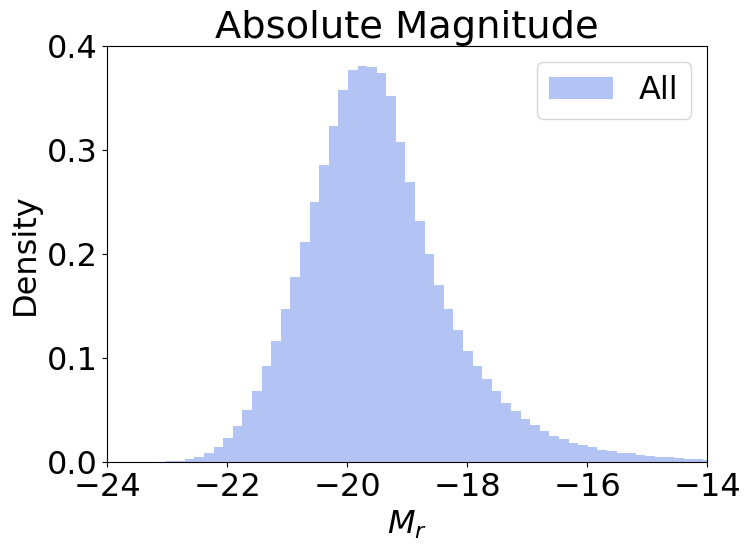

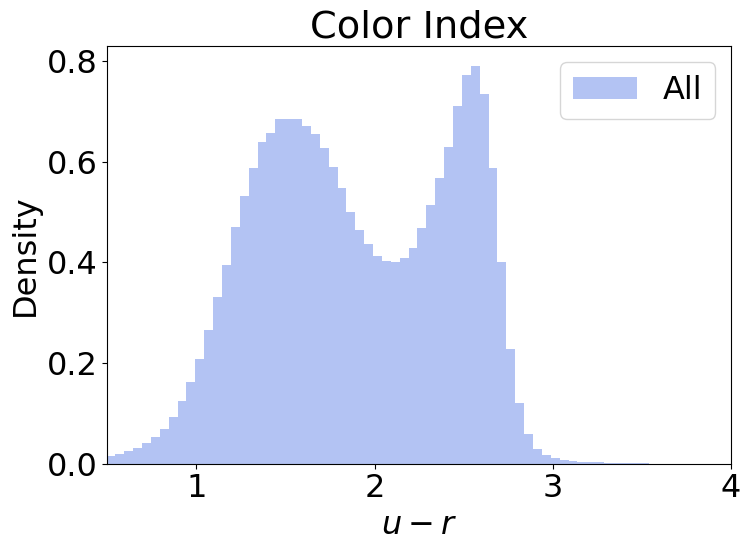

In [6]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 23})

# Absolute Magnitude
plt.figure(figsize=(8, 6))
plt.hist(abs_mag_r_total, bins=150, density=True,
         alpha=0.4, color='royalblue', label='All')

plt.xlabel(r"$M_r$")
plt.ylabel("Density")
plt.title("Absolute Magnitude")
plt.legend()
plt.xlim(-24, -14)
plt.tight_layout()
plt.savefig("VF_Absolute_Magnitude_filled.pdf", bbox_inches='tight')
plt.show()

# Color Index (u - r)
plt.figure(figsize=(8, 6))
plt.hist(ur_total, bins=150, density=True,
         alpha=0.4, color='royalblue', label='All')

plt.xlabel(r"$u - r$")
plt.ylabel("Density")
plt.title("Color Index")
plt.legend()
plt.xlim(0.5, 4)
plt.tight_layout()
plt.savefig("VF_Color_UR_filled.pdf", bbox_inches='tight')
plt.show()


## Plots for galaxy properties

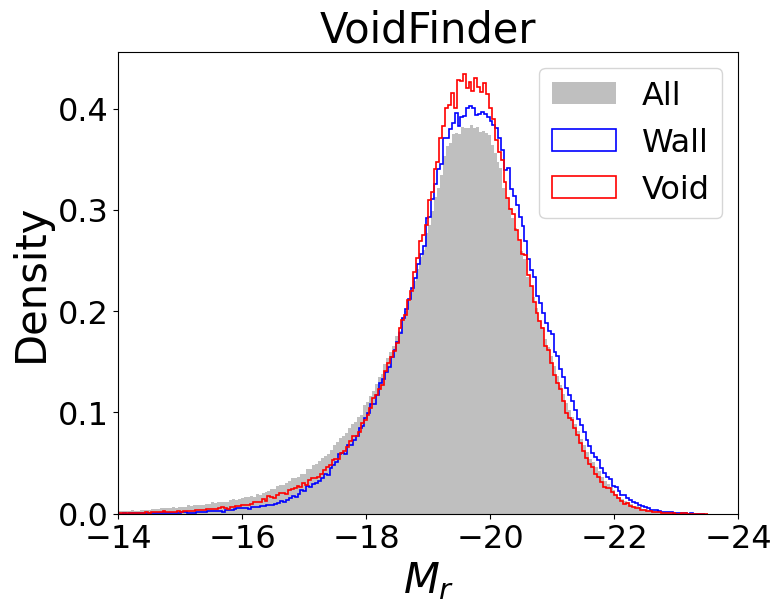

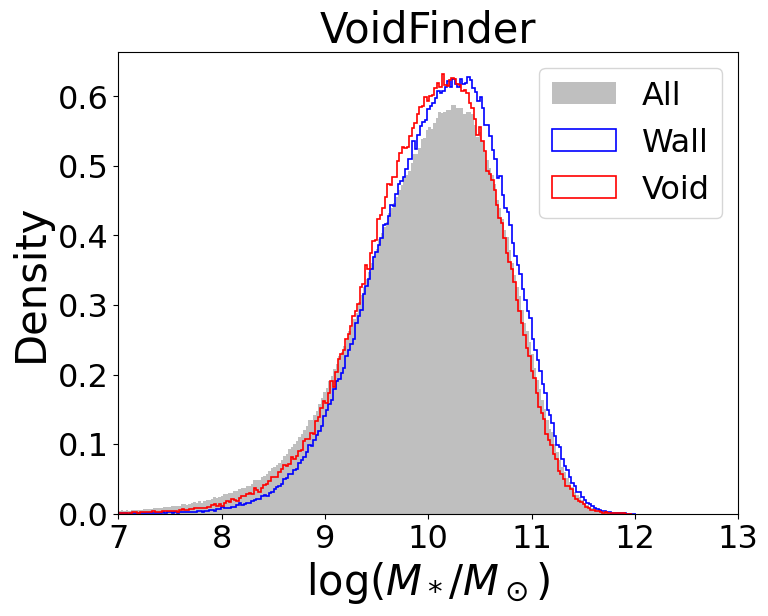

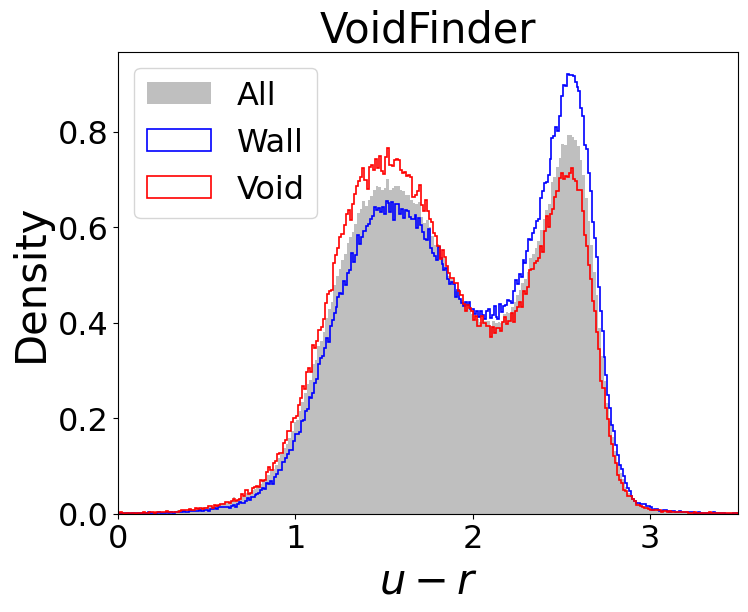

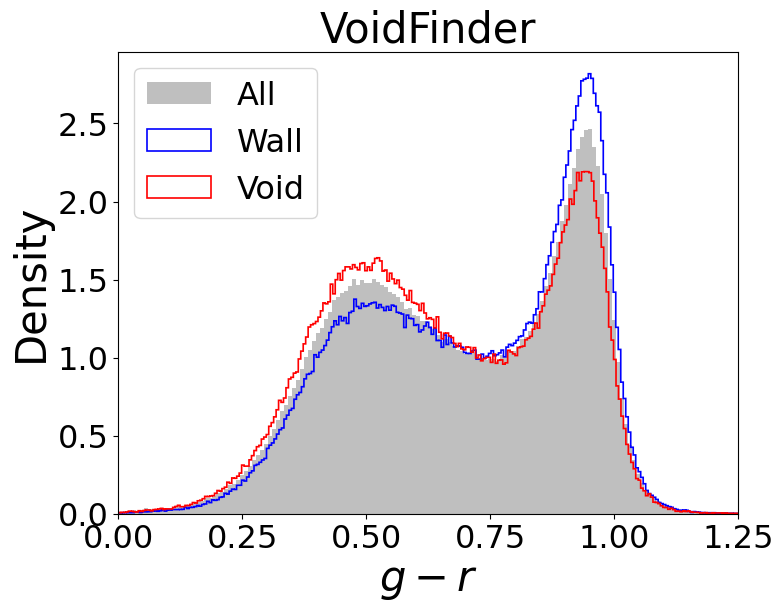

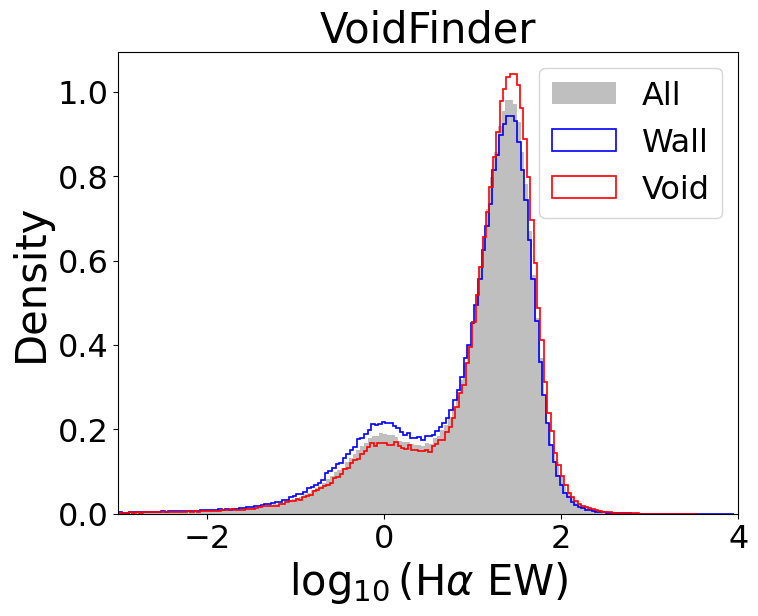

In [7]:
plt.rcParams.update({'font.size': 23})

# 1. Absolute Magnitude (M_r)

size = 30

plt.figure(figsize=(8, 6))
plt.hist(abs_mag_r_total, bins=500, density=True, alpha=0.5, color='gray', label='All')
plt.hist(wall_abs_mag_VF, bins=500, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='blue', label='Wall')
plt.hist(void_abs_mag_VF, bins=500, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='red', label='Void')
plt.xlabel(r"$M_r$", fontsize=size)
plt.ylabel("Density", fontsize=size)
plt.title("VoidFinder", fontsize=size)
plt.legend()
plt.xlim(-14, -24)
plt.savefig("VF_Absolute_Magnitude.pdf", bbox_inches='tight')
plt.show()

# 2. Stellar Mass (Log M_star)
plt.figure(figsize=(8, 6))
plt.hist(logmstar_total, bins=500, density=True, alpha=0.5, color='gray', label='All')
plt.hist(wall_log_mstar_VF, bins=500, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='blue', label='Wall')
plt.hist(void_log_mstar_VF, bins=500, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='red', label='Void')
plt.xlabel(r'$\log({M_*}/{M_\odot})$', fontsize=size)
plt.ylabel("Density", fontsize=size)
plt.title("VoidFinder", fontsize=size)
plt.legend()
plt.xlim(7, 13)
plt.savefig("VF_Stellar_Mass.pdf", bbox_inches='tight')
plt.show()

# 3. Color (u-r)
plt.figure(figsize=(8, 6))
plt.hist(ur_total, bins=500, density=True, alpha=0.5, color='gray', label='All')
plt.hist(wall_color_ur_VF, bins=500, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='blue', label='Wall')
plt.hist(void_color_ur_VF, bins=500, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='red', label='Void')
plt.xlim(0,3.5)
plt.xlabel(r"$u-r$", fontsize=size)
plt.ylabel("Density", fontsize=size)
plt.title("VoidFinder", fontsize=size)
plt.legend()
plt.savefig("VF_Color_ur.pdf", bbox_inches='tight')
plt.show()

# 4. Color (g-r)
plt.figure(figsize=(8, 6))
plt.hist(gr_total, bins=800, density=True, alpha=0.5, color='gray', label='All')
plt.hist(wall_color_gr_VF, bins=800, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='blue', label='Wall')
plt.hist(void_color_gr_VF, bins=800, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='red', label='Void')
plt.xlim(0,1.25)
plt.xlabel(r"$g-r$", fontsize=size)
plt.ylabel("Density", fontsize=size)
plt.title("VoidFinder", fontsize=size)
plt.legend()
plt.savefig("VF_Color_gr.pdf", bbox_inches='tight')
plt.show()

# 5. Halpha EW (log scale)
HalphaEW_array = np.array(HalphaEW)
wall_HalphaEW_VF_array = np.array(wall_HalphaEW_VF)
void_HalphaEW_VF_array = np.array(void_HalphaEW_VF)

HalphaEW_positive = HalphaEW_array[HalphaEW_array > 0]
wall_HalphaEW_VF_positive = wall_HalphaEW_VF_array[wall_HalphaEW_VF_array > 0]
void_HalphaEW_VF_positive = void_HalphaEW_VF_array[void_HalphaEW_VF_array > 0]

HalphaEW_log = np.log10(HalphaEW_positive)
wall_HalphaEW_VF_log = np.log10(wall_HalphaEW_VF_positive)
void_HalphaEW_VF_log = np.log10(void_HalphaEW_VF_positive)

plt.figure(figsize=(8, 6))
plt.hist(HalphaEW_log, bins=500, density=True, alpha=0.5, color='gray', label='All')
plt.hist(wall_HalphaEW_VF_log, bins=500, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='blue', label='Wall')
plt.hist(void_HalphaEW_VF_log, bins=500, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='red', label='Void')
plt.xlabel(r"$\log_{10}(\mathrm{H}\alpha~\mathrm{EW})$", fontsize=size)
plt.ylabel("Density", fontsize=size)
plt.title("VoidFinder", fontsize=size)
plt.legend()
plt.xlim(-3, 4)
plt.savefig("VF_HalphaEW.pdf", bbox_inches='tight')
plt.show()


# Slice Plot

In [8]:
from vast.catalog.void_catalog import VoidFinderCatalog
from vast.catalog.void_slice_plots import VoidMapVF

In [9]:
# modify column name
from astropy.table import Table

input_file = 'BGS_classified_galaxies.fits'
output_file = 'BGS_classified_galaxies_modified.fits'

galaxies = Table.read(input_file, format='fits')

print("Original column names:", galaxies.colnames)

if 'ABS_MAG_R' in galaxies.colnames:
    galaxies.rename_column('ABS_MAG_R', 'rmag')
    print("APP_MAG rename as rmag")
else:
    print("Error: 'APP_MAG' doesn't exist")

galaxies.write(output_file, format='fits', overwrite=True)

print(f"save as: {output_file}")


Original column names: ['Z', 'DEC', 'RA', 'ABS_MAG_R', 'ABS_MAG_U', 'ABS_MAG_G', 'LOG_MSTAR', 'HALPHA', 'HBETA', 'SFR', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'Color_ur', 'Color_gr', 'Halpha_EW', 'ra', 'dec', 'redshift', 'Rgal', 'vflag']
APP_MAG rename as rmag
save as: BGS_classified_galaxies_modified.fits


In [10]:
classified_galaxies = Table.read('BGS_classified_galaxies_modified.fits', format='fits')

print("Column names in classified_galaxies.fits:")
print(classified_galaxies.colnames)

Column names in classified_galaxies.fits:
['Z', 'DEC', 'RA', 'rmag', 'ABS_MAG_U', 'ABS_MAG_G', 'LOG_MSTAR', 'HALPHA', 'HBETA', 'SFR', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'Color_ur', 'Color_gr', 'Halpha_EW', 'ra', 'dec', 'redshift', 'Rgal', 'vflag']


In [11]:
ngc_file = 'DESIVAST_NGC_VoidFinder_Output.fits'
galaxy_file = "BGS_classified_galaxies_modified.fits"

galaxies = Table.read(galaxy_file, format='fits')

vflag_column = galaxies['vflag']

voidfinder_catalog = VoidFinderCatalog(ngc_file)
voidfinder_catalog.add_galaxies(galaxy_file)


In [12]:
voidfinder_catalog.galaxies['rabsmag'] = -30

In [13]:
def redtext(text):
    return f"\x1b[31m{text}\x1b[0m"

print('\n'+redtext("VoidFinder"),'\n')
voidfinder_catalog.void_stats()


VoidFinder 

3246 voids
1881 edge voids
38 near-edge voids
1327 interior voids
68 edge voids (V. Fid)
2 near-edge voids (V. Fid)
860 interior voids (V. Fid)
Mean Reff (V. Fid): 16.53 +/- 0.0554 Mpc/h
Median Reff (V. Fid): 15.73 +/- 0.0695 Mpc/h
Maximum Reff (V. Fid): 31.32 Mpc/h


In [14]:
print(voidfinder_catalog.maximals["ra","dec"][:5])
voidfinder_catalog.galaxies[:5]

        ra                dec        
------------------ ------------------
 192.0918608937389 -7.617182432036663
237.73575505720598   8.12007895388944
256.47295103438404 14.213058577945016
250.32849317150055  4.423619087144855
172.33831693615068 -6.864174636878769


Z,DEC,RA,rmag,ABS_MAG_U,ABS_MAG_G,LOG_MSTAR,HALPHA,HBETA,SFR,FLUX_G,FLUX_R,FLUX_Z,Color_ur,Color_gr,Halpha_EW,ra,dec,redshift,Rgal,vflag,gal,x,y,z,rabsmag
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,float32,float32,float32,int64
0.05780038,-18.21877,12.6733265,-14.485381,-13.126825,-13.983046,8.39407,9.384184,1.7261547,0.0040072696,0.0,0.0,0.0,1.3585558,0.50233555,20.035814,12.6733265,-18.21877,0.05780038,170.89012,9,0,158.36862,35.61245,-53.428135,-30
0.039262295,-17.952065,62.54219,-14.929324,-13.283367,-14.270424,8.102492,12.095114,2.3138983,0.031769145,0.0,0.0,0.0,1.645957,0.65890026,5.7975755,62.54219,-17.952065,0.039262295,116.60562,9,1,51.14868,98.4326,-35.940323,-30
0.044535317,-17.734976,49.11157,-14.197081,-12.78465,-13.801654,7.4312687,0.4037834,0.34406868,0.01169814,0.0,0.0,0.0,1.4124308,0.39542675,0.52964616,49.11157,-17.734976,0.044535317,132.09723,9,2,82.3599,95.11765,-40.23874,-30
0.09241165,-17.67581,61.798813,-15.879556,-14.261594,-15.437478,8.104299,2.8001018,0.23186865,0.0,0.0,0.0,0.0,1.6179619,0.44207764,3.8032098,61.798813,-17.67581,0.09241165,270.8993,9,3,121.97483,227.47076,-82.25337,-30
0.08739562,-17.65079,65.80761,-16.675762,-16.531595,-16.710188,8.710713,46.500267,10.416571,0.20935676,0.0,0.0,0.0,0.14416695,-0.034425735,32.517788,65.80761,-17.65079,0.08739562,256.51437,9,4,100.171265,222.97035,-77.77893,-30


In [15]:
# Get the declination values from maximals
dec_values = voidfinder_catalog.maximals['dec']

# Calculate the range (min and max)
dec_min = np.min(dec_values)
dec_max = np.max(dec_values)
dec_range = dec_max - dec_min

# Calculate the mean
dec_mean = np.mean(dec_values)

# Print the results
print(f"Declination Range: {dec_min} to {dec_max}")
print(f"Range (Max - Min): {dec_range}")
print(f"Mean Declination: {dec_mean}")


Declination Range: -9.60100807808083 to 70.02105319218312
Range (Max - Min): 79.62206127026394
Mean Declination: 11.712829841469375


In [16]:
vflag_table = Table([galaxies['vflag']], names=['vflag'])

vflag_file = 'ngc_vflags.fits'
vflag_table.write(vflag_file, format='fits', overwrite=True)

In [17]:
if 'rmag' in voidfinder_catalog.galaxies.colnames:
    rmag_numpy = np.array(voidfinder_catalog.galaxies['rmag'], dtype=np.float32)
    voidfinder_catalog.galaxies.remove_column('rmag')
    voidfinder_catalog.galaxies['rmag'] = rmag_numpy
    print("rmag convert to numpy array, float32.")
else:
    print("Error: 'rmag' column doesn't exist")

voidfinder_slice_plot = VoidMapVF(
    voidfinder_catalog.galaxies, 
    voidfinder_catalog.maximals, 
    voidfinder_catalog.holes
)

voidfinder_slice_plot.rmag = np.array(voidfinder_catalog.galaxies['rmag'], dtype=np.float32)


rmag convert to numpy array, float32.


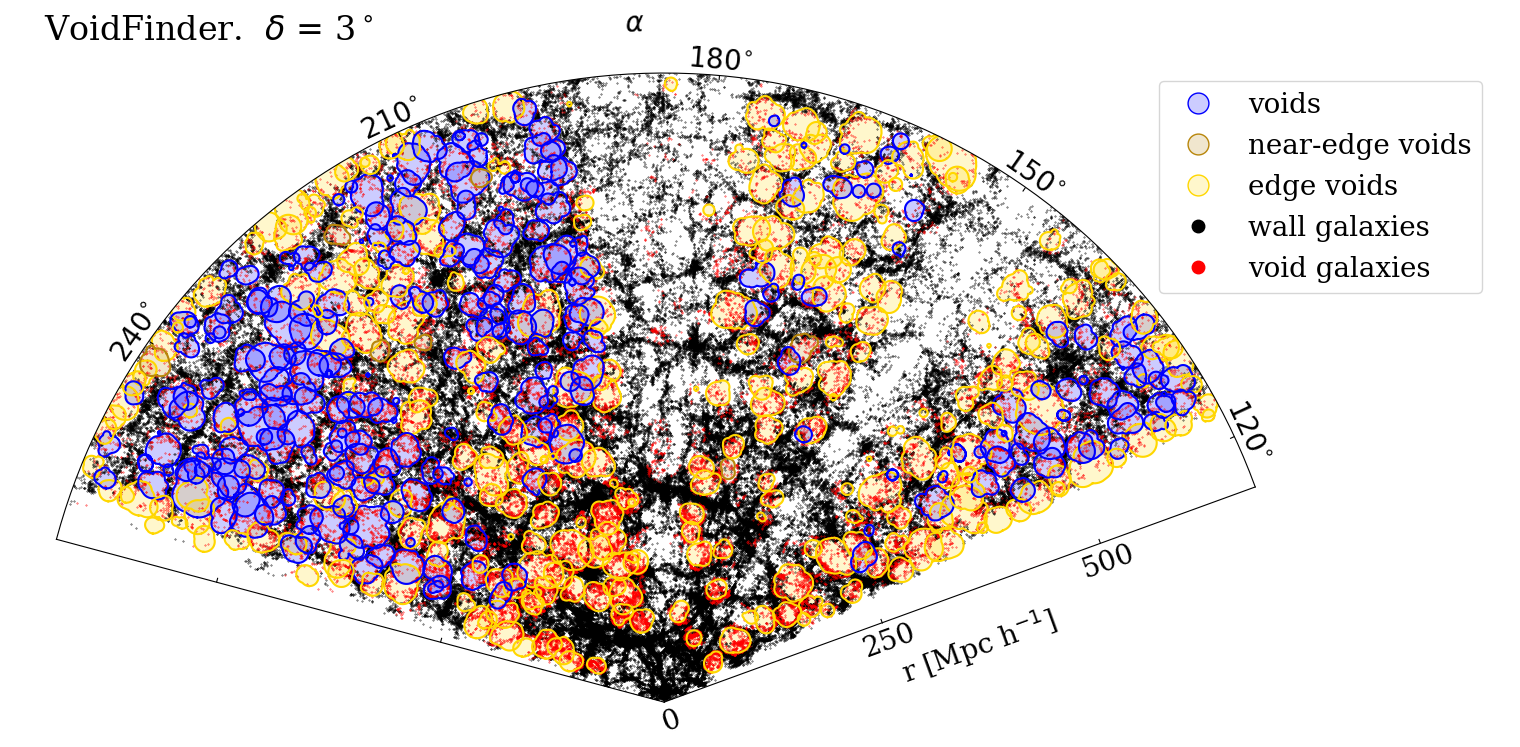

In [18]:
# Slice plot
plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })

# Parameters: dec, wdth, npc, chkdpth, ra0, ra1, cz0, cz1, title, graph, 
#zlimits, rot, colors, gal_colors, include_gals, include_voids, alpha,
#border_alpha, horiz_legend_offset, plot_sdss, sdss_lim, sdss_color, mag_limit, galaxy_point_size, return_plot_data

graph = voidfinder_slice_plot.plot_survey(3, 10, 1500, 15, 
    115, 260, 0, 0.24, "VoidFinder. ", graph = None, zlimits = True, rot = 265, 
    colors = ['gold','darkgoldenrod','blue'],include_gals=True, include_voids=True, alpha=0.2, border_alpha = 1,
    horiz_legend_offset=0.9,mag_limit=-10, galaxy_point_size=.1, plot_sdss=False)

In [19]:
# Save result
graph[0].figure.savefig(
    "BGSbright_voidfinder_slice_plot.png",
    format="png",       
    bbox_inches="tight", 
    dpi=150          
)

# Apply Bayesian Nonparametric and Calculate the Bayes factor

In [20]:
def pt_d_sample_test(data1, data2, c = 1, max_depth=-1, qdist=norm.ppf, aj=lambda depth: depth**2, log_BF=False):
    if max_depth < 0:

       max_depth = 6   # set tree depth

    binary = np.concatenate((np.zeros(len(data1)), np.ones(len(data2))))
    continuous = np.concatenate((data1, data2))
    data = np.column_stack([scale(continuous), binary])   #with two columns
    X = data[:, 0]  # assign the first column to X
    discrete_values = np.unique(binary)    #[0,1]

    p_H0 = pt_marginal_likelihood(X, low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)

    p_H1 = max([pt_marginal_likelihood(data[data[:, 1] == i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj) +
                pt_marginal_likelihood(data[data[:, 1] != i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)
                for i in discrete_values])

    logbf = p_H0 - p_H1

    if log_BF:
        return logbf
    else:
        bf = np.exp(logbf)
        return bf

def pt_marginal_likelihood(data, low, up, c, depth, max_depth, qdist, aj):
    if depth == max_depth:
        return 0

    if isinstance(low, (int, float)):  # if low is an integer
        n_j = [
            np.sum((qdist(low) < data) & (data <= qdist((low + up) / 2))),
            np.sum((qdist((low + up) / 2) < data) & (data <= qdist(up)))
        ]   #counts the number of data in each interval


    if np.sum(n_j) == 0:
        return 0

    a_j = c * aj(depth)    #alpha

    if len(n_j) == 2:
        logl = betaln(n_j[0] + a_j, n_j[1] + a_j) - betaln(a_j, a_j)  #natural log of beta function
        likelihoods = [
            pt_marginal_likelihood(data, low, (low + up) / 2, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, (low + up) / 2, up, c, depth + 1, max_depth, qdist, aj)
        ]  # likelihood of subpartitions


    return logl + np.sum(likelihoods)

def scale(data):
    return (data - np.mean(data)) / np.std(data)      #standardize

In [21]:
# Absolute Magnitude
bf_Mr = pt_d_sample_test(wall_abs_mag_VF, void_abs_mag_VF, log_BF=True)

# Stellar Mass
bf_mass = pt_d_sample_test(wall_log_mstar_VF, void_log_mstar_VF, log_BF=True)

# u-r Color
bf_ur = pt_d_sample_test(wall_color_ur_VF, void_color_ur_VF, log_BF=True)

# g-r Color
bf_gr = pt_d_sample_test(wall_color_gr_VF, void_color_gr_VF, log_BF=True)

# log10(Halpha EW)
bf_Ha = pt_d_sample_test(wall_HalphaEW_VF_log, void_HalphaEW_VF_log, log_BF=True)


In [22]:
bf_results = {
    "Absolute Magnitude": bf_Mr,
    "Stellar Mass": bf_mass,
    "Color (u-r)": bf_ur,
    "Color (g-r)": bf_gr,
    "log10(Hα EW)": bf_Ha
}

bf_results

{'Absolute Magnitude': -1305.1323690074496,
 'Stellar Mass': -1899.3492243085057,
 'Color (u-r)': -3582.747693415731,
 'Color (g-r)': -3946.2821629433893,
 'log10(Hα EW)': -2401.738067107741}